In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os as os
import tensorflow as tf
import zipfile

In [ ]:
import tensorflow as tf
device_name = tf.config.list_physical_devices('GPU')
if len(device_name) > 0 :
  print(f"Using GPU ".format(device_name))
else:
  print(f"GPU not in use ".format(device_name))

Using GPU 


In [ ]:
PATH = "/content/drive/MyDrive/Leaf1"
train_dir = os.path.join(PATH, 'Train')
validation_dir = os.path.join(PATH, 'Validate')
BATCH_SIZE = 32
IMG_SIZE = (64, 64) #for CNN

In [ ]:
!unzip "/content/drive/MyDrive/Tomato___Bacterial_spot_train.zip" -d "/content/drive/MyDrive/Leaf1/Train"
!unzip "/content/drive/MyDrive/Tomato___healthy_train.zip" -d "/content/drive/MyDrive/Leaf1/Train"
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Leaf1/Train/Tomato___Bacterial_spot/ac444acf-1d85-4928-9f73-947497fb6b9f___GCREC_Bact.Sp 5762 (2).JPG  
  inflating: /content/drive/MyDrive/Leaf1/Train/Tomato___Bacterial_spot/ac444acf-1d85-4928-9f73-947497fb6b9f___GCREC_Bact.Sp 5762.JPG  
  inflating: /content/drive/MyDrive/Leaf1/Train/Tomato___Bacterial_spot/acbad9e6-d801-48d5-92ee-9fae23fcfb93___UF.GRC_BS_Lab Leaf 0250 (2).JPG  
  inflating: /content/drive/MyDrive/Leaf1/Train/Tomato___Bacterial_spot/acbad9e6-d801-48d5-92ee-9fae23fcfb93___UF.GRC_BS_Lab Leaf 0250.JPG  
  inflating: /content/drive/MyDrive/Leaf1/Train/Tomato___Bacterial_spot/acbc36cd-9c39-419b-95da-7858806a063a___GCREC_Bact.Sp 3811 (2).JPG  
  inflating: /content/drive/MyDrive/Leaf1/Train/Tomato___Bacterial_spot/acbc36cd-9c39-419b-95da-7858806a063a___GCREC_Bact.Sp 3811.JPG  
  inflating: /content/drive/MyDrive/Leaf1/Train/Tomato___Bacterial_spot/acc8c3ba-69bc-4900-9c78-f7140e68f62d___

In [ ]:
!unzip "/content/drive/MyDrive/Tomato___Bacterial_spot_validate.zip" -d "/content/drive/MyDrive/Leaf1/Validate"
!unzip "/content/drive/MyDrive/Tomato___healthy_validate.zip" -d "/content/drive/MyDrive/Leaf1/Validate"
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Archive:  /content/drive/MyDrive/Tomato___Bacterial_spot_validate.zip
  inflating: /content/drive/MyDrive/Leaf1/Validate/Tomato___Bacterial_spot/014b58ae-091b-408a-ab4a-5a780cd1c3f3___GCREC_Bact.Sp 2971 (2).JPG  
  inflating: /content/drive/MyDrive/Leaf1/Validate/Tomato___Bacterial_spot/014b58ae-091b-408a-ab4a-5a780cd1c3f3___GCREC_Bact.Sp 2971.JPG  
  inflating: /content/drive/MyDrive/Leaf1/Validate/Tomato___Bacterial_spot/01d7f4fe-793f-4a9b-bc8b-8aa05200984f___GCREC_Bact.Sp 2984 (2).JPG  
  inflating: /content/drive/MyDrive/Leaf1/Validate/Tomato___Bacterial_spot/01d7f4fe-793f-4a9b-bc8b-8aa05200984f___GCREC_Bact.Sp 2984.JPG  
  inflating: /content/drive/MyDrive/Leaf1/Validate/Tomato___Bacterial_spot/01d9fc8d-5083-468d-a583-885f33517cdd___GCREC_Bact.Sp 3422 (2).JPG  
  inflating: /content/drive/MyDrive/Leaf1/Validate/Tomato___Bacterial_spot/01d9fc8d-5083-468d-a583-885f33517cdd___GCREC_Bact.Sp 3422.JPG  
  inflating: /content/drive/MyDrive/Leaf1/Validate/Tomato___Bacterial_spot/022e8a4a-

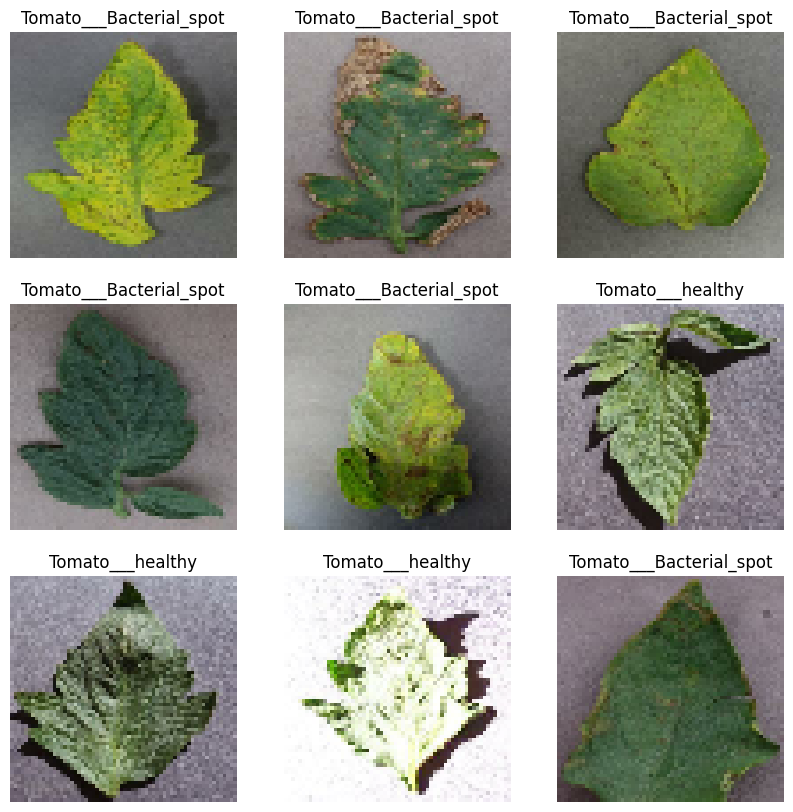

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# validation dataset is divided into two parts 1- test(consisting of 1/5th images from the validation dataset) 2- modified validation (consisting of rest of 4/5 th set of images)
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 46
Number of test batches: 11


In [ ]:
#Use buffered prefetching to load images from disk without having I/O become blocking.
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

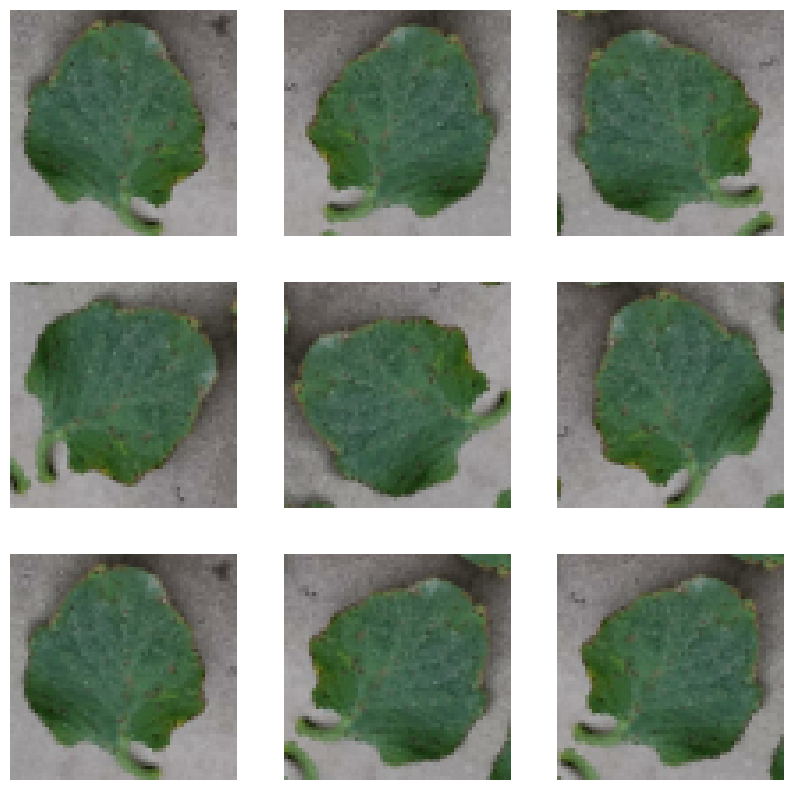

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

# Initialising the CNN

CNN_Classifier=Sequential();

# Step 1 - Convolution
CNN_Classifier.add(Conv2D(32,(3,3),input_shape=(64,64,3),activation='relu'))

# Step 2 - Pooling
CNN_Classifier.add(MaxPooling2D(pool_size=(2,2)))

# Step 1 - Convolution
CNN_Classifier.add(Conv2D(16,(3,3),activation='relu'))

# Step 2 - Pooling
CNN_Classifier.add(MaxPooling2D(pool_size=(2,2)))


# Step 3 - Flattening
CNN_Classifier.add(Flatten())


# Step 4 - Full connection

CNN_Classifier.add(Dense(units=128, activation='relu'))
CNN_Classifier.add(Dense(units=1, activation='sigmoid'))

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = CNN_Classifier(image_batch)
print(feature_batch.shape)

(32, 1)


In [ ]:
CNN_Classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)              

In [ ]:
# Compiling the CNN
CNN_Classifier.compile(optimizer ='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
%%time
history = CNN_Classifier.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset
)

Epoch 1/10
227/227 [==============================] - 20s 67ms/step - loss: 2.1769 - accuracy: 0.9347 - val_loss: 0.0233 - val_accuracy: 0.9904
Epoch 2/10
227/227 [==============================] - 14s 60ms/step - loss: 0.0674 - accuracy: 0.9779 - val_loss: 0.0122 - val_accuracy: 0.9973
Epoch 3/10
227/227 [==============================] - 17s 72ms/step - loss: 0.0679 - accuracy: 0.9830 - val_loss: 0.0301 - val_accuracy: 0.9911
Epoch 4/10
227/227 [==============================] - 15s 65ms/step - loss: 0.0215 - accuracy: 0.9952 - val_loss: 0.0155 - val_accuracy: 0.9966
Epoch 5/10
227/227 [==============================] - 15s 63ms/step - loss: 0.0120 - accuracy: 0.9974 - val_loss: 0.0150 - val_accuracy: 0.9959
Epoch 6/10
227/227 [==============================] - 14s 61ms/step - loss: 0.0100 - accuracy: 0.9974 - val_loss: 0.0136 - val_accuracy: 0.9979
Epoch 7/10
227/227 [==============================] - 14s 62ms/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 0.0117 - val_accuracy:

In [ ]:
loss, accuracy = CNN_Classifier.evaluate(test_dataset)
print('Test accuracy :', accuracy)

11/11 [==============================] - 1s 47ms/step - loss: 0.0254 - accuracy: 0.9915
Test accuracy : 0.9914772510528564


Predictions:
 [0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0]
Labels:
 [0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0]


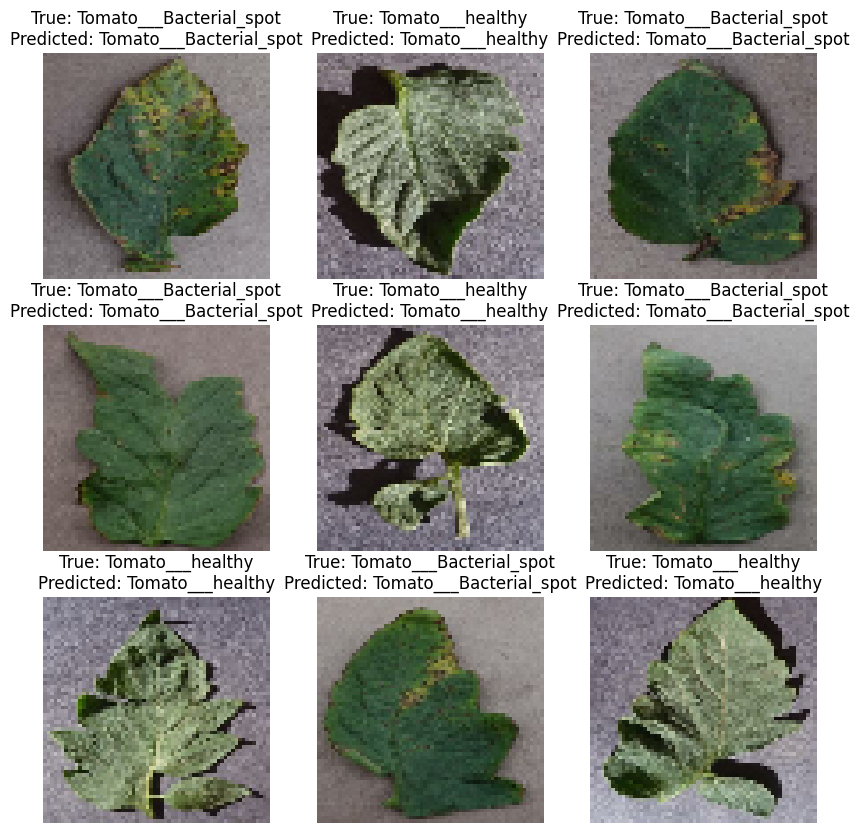

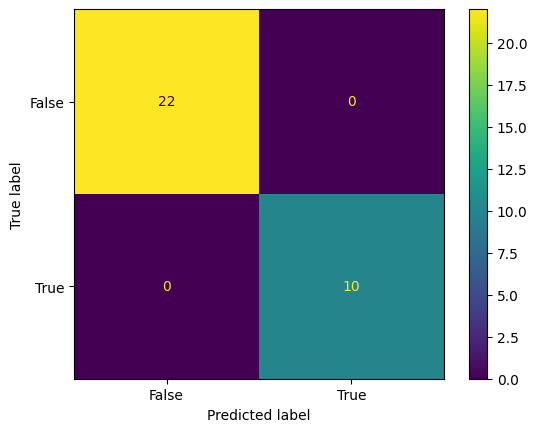

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        10

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = CNN_Classifier.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions <0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f"True: {class_names[label_batch[i]]}\nPredicted: {class_names[predictions[i]]}")
  plt.axis("off")
  from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(label_batch, predictions.numpy())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
import matplotlib.pyplot as plt
cm_display.plot()
plt.show()
from sklearn.metrics import classification_report
print(classification_report(label_batch, predictions.numpy()))